# Football Prediction
---

Our task is to predict the probabilities of full-time football scores for home and away teams using two mystery features x and y. The model we will use to achieve this is a sparse variational Gaussian process (SVGP) with a Matérn 5/2 kernel and a Poisson likelihood.

### Import Dependencies
---

Let's import some useful packages, namely TensorFlor and GPflow as well as some custom plotting and optimisation functions.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import gpflow as gpf
import tensorflow as tf
import matplotlib.pyplot as plt

from gpflow.kernels import Matern52
from gpflow.likelihoods import Poisson
from gpflow.models import SVGP

from src.optimisation import optimise_svgp_with_adam
from src.plotting import plot_feature_distributions, plot_targets_2D, plot_elbos

### Load Dataset
---

Let's load the dataset as a Pandas DataFrame.

In [2]:
data = pd.read_csv("data/dataset.csv", index_col=0)
data.head()

,team_event_id,x,y,ht_home,ht_away,ft_home,ft_away
0,2512081,3.304210,-2.097264,0.0,1.0,0.0,3.0
1,2512082,2.787051,-1.014194,0.0,0.0,1.0,0.0
2,2512083,2.443578,1.181806,0.0,1.0,0.0,2.0
3,2512084,2.254428,0.206387,0.0,0.0,0.0,2.0
4,2512088,3.168832,1.591534,2.0,0.0,2.0,1.0


### Analyse, Visualise and Clean Dataset
---

Before setting up our model, let's take some time to analyse our dataset and check for outliers. Let's start by counting the number of NaN values in the dataset and see what proprtion of the total dataset they represent.

In [3]:
num_data = data.shape[0]
num_nans = data.isnull().values.sum()
print(f"NaN proportion: {num_nans / num_data :.5f}")

NaN proportion: 0.00023


Since the NaN values represent a small subset of the total datapoints, let's just drop them from the dataset.

In [4]:
data = data.dropna(axis=0)

Now let's impose some constraints on the possible values of goals scored. Goals must be non-negative, and while the theoretical maximum number of goals possible to score in a 90 minute match is probably somewhere in the hundreds or thousands, the practical limit is much lower. A quick Google search tells us that the highest-scoring Premier League match of all-time was an 11-goal matchup between Portsmouth and Reading in 2007 with a final score of 7-4. We don't know if the dataset we have is for professional or amateur matches, but it's likely that there is higher variance in the final scores of amateur matches, so let's cap our goals scored at 15.

In [5]:
data = data.drop(data[(data["ft_home"] < 0) | (data["ft_home"] > 15)].index)
data = data.drop(data[(data["ft_away"] < 0) | (data["ft_away"] > 15)].index)

It's difficult to impose constraints on our mystery features x and y since we don't know what they are. So for now, let's just plot some histograms of the continuous features x and y and bar charts of our count-valued targets ft_home and ft_away.

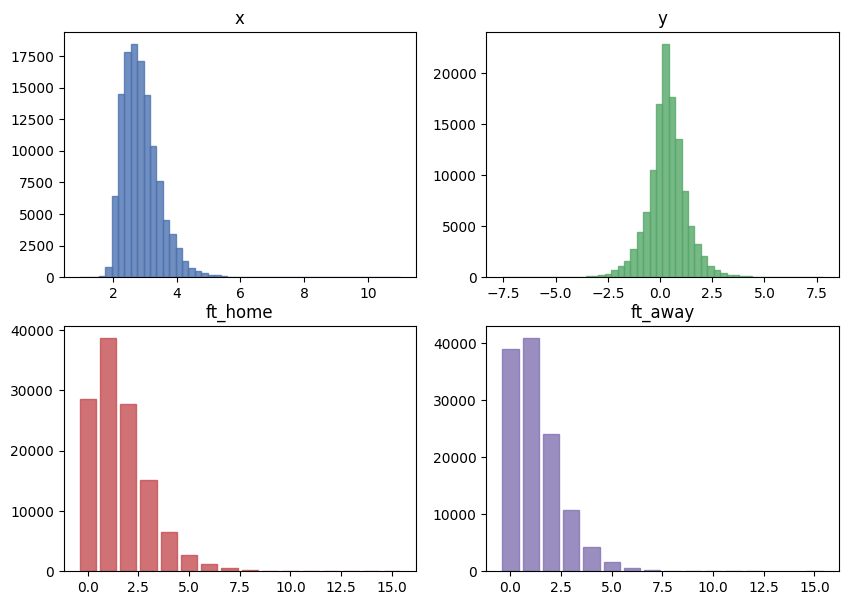

In [6]:
fig = plot_feature_distributions(data, figsize=(10, 7))
plt.show()

Overall, the distributions above look pretty sensible and there are no glaring outliers :) Out of curiosity, let's check how correlated our input features are with our target variables.

In [7]:
print("Correlation with home team score")
print(data[["x", "y"]].corrwith(data["ft_home"]))
print("\nCorrelation with away team score")
print(data[["x", "y"]].corrwith(data["ft_away"]))

Correlation with home team score
x    0.246641
y    0.378689
dtype: float64

Correlation with away team score
x    0.174347
y   -0.358451
dtype: float64


These are relatively weak correlations :( This likely means that for a given value of x and y, there is significant variance in the possible values of our target values. Let's verify this by plotting the home team and away team scores vs. the mystery features x and y (we'll create a 2D/top-down plot with datapoints colour-coded based on their target values as count data looks a little weird in 3D).

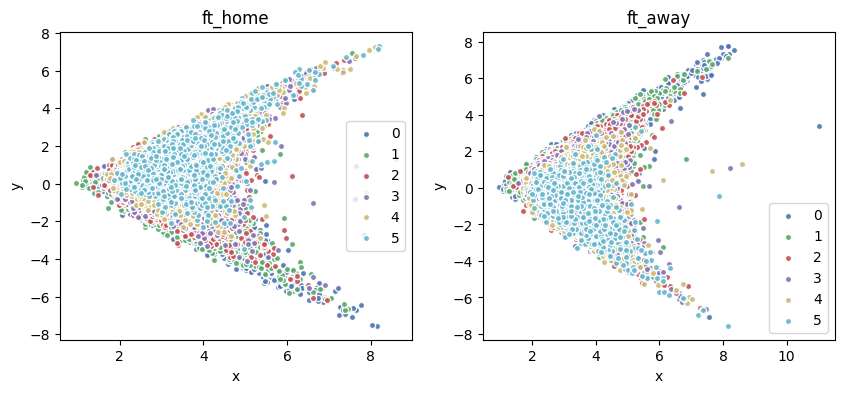

In [8]:
fig = plot_targets_2D(data, figsize=(10, 4))

While there are certainly visible correlations between the target values and the mystery features (i.e. higher home team scores and lower away team scores appear to correspond with higher values of y in general), for most values of x and y, there are multiple possible target values. This means it's unlikely that given the features x and y we will be able to train a model with high mean accuracy (i.e. consistently predict the exact scores), but we can try and learn the distribution of goals well (i.e. learn which scores are more likely than others).

One key modelling decision we need to make is whether to model the home and away scores separately, or create a joint model. Multi-output regression is more complicated to implement than single-output regression, but if there is strong covariance between the home and away scores, it is important to capture this in our model. We can do a quick check by computing the Pearson correlation coefficient between home and away scores.

In [9]:
corr = np.corrcoef(data["ft_home"], data["ft_away"])
print(f"Correlation between home and away scores: {corr[0][1]:.5f}")

Correlation between home and away scores: -0.09048


This is a very low correlation coefficient. The fact that home and away scores are weakly correlated makes sense intuitively, as there is no obvious reason why if one team scores many goals the other should be more or less likely to also score many goals. As such, we will go ahead and model the home and away scores separately.

### Partition Training and Test Data
---

The last thing to do before setting up our model(s) is to split our dataset into a training and test set. Let's shuffle the dataset and do a 70/30 train/test split.

In [10]:
# 70/30 random split
train_proportion = 0.7
train_mask = np.random.rand(len(data)) < train_proportion
data_train = data[train_mask]
data_test = data[~train_mask]

# Extract training features + labels
features_train = data_train[["x", "y"]].values
home_score_train = data_train[["ft_home"]].values
away_score_train = data_train[["ft_away"]].values
home_train_data = (features_train, home_score_train)
away_train_data = (features_train, away_score_train)

# Extract test features and labels
features_test = data_test[["x", "y"]].values
home_score_test = data_test[["ft_home"]].values
away_score_test = data_test[["ft_away"]].values
home_test_data = (features_test, home_score_test)
away_test_data = (features_test, away_score_test)

### Model Setup
---

**Note**: We will overload some notation here. From here on, we will no longer distinguish between mystery features $x_i$ and $y_i$ for a given match $i$, but will concatenate them into a vector $\mathbf{x}_i = (x_i, y_i) \in \mathbb{R}^2$. We will stack all the $N$ feature vectors $\mathbf{x}_i$ into the matrix $\mathbf{X} = \{(x_i, y_i)\}_{i=1}^{N} \in \mathbb{R}^{N \times 2}$. We will use $y_i$ to refer to the target variable (number of goals) corresponding to match $i$, and stack all the targets into the vector $\mathbf{y} = \{y_i\}_{i=1}^{N} \in \mathbb{R}^{N \times 1}$.

Predicting the number of home/away goals $\mathbf{y}$ given the mystery features $\mathbf{X}$ is ultimately a regression task, but our target variable is discrete (count data) and has very high variance, so capturing the uncertainty in our predictions is imperative. Gaussian Processes are a powerful class of models for uncertainty-aware regression tasks and are also extremely flexible for modelling non-Gaussian data, so we will use a Gaussian Process to learn the relationship between our mystery features and target distributions. Since football matches occur in a fixed interval of time and all matches are essentially independent (ignoring psychological factors like changes in morale resulting from a series of consecutive wins or losses), it is natural to model the number of goals scored in each match with a fully-factorised Poisson likelihood. We will assume there is some latent function $\mathbf{f}$ which learns the rate parameter of the Poisson distribution (after pushing it through an exponential inverse link function to ensure its non-negativity). Our fully-factorised Poisson likelihood is thus given by:

$p(\mathbf{y}|\mathbf{f}) = \prod_{i=1}^{N} \frac{\lambda_{i}^{y_i} \exp(-\lambda_i)} {y_i!}$

where

$\lambda_i = \exp (f_i)$

and $f_i$ is the latent function, modelled by a Gaussian process. Since a Poisson likelihood is non-conjugate with our GP prior (Gaussian), we need to use some sort of approximate inference to learn the posterior, like MCMC or variational inference. In addition, our training dataset is relatively large ($N \approx 100,000$), so even with a conjugate likelihood, exact inference would be computationally intractable due to the $\mathcal{O}(N^3)$ matrix inversion required to compute the marginal likelihood and posterior. We will therefore use a sparse variational Gaussian Process (SVGP) model, which can accomodate both our non-conjugate Poisson likelihood as well as our large dataset. In order to construct our SVGP, we introduce a set of $M$ "inducing variables" (or pseudo-datapoints) $\mathbf{u} = f(\mathbf{Z})$ to our joint probability model along with our observations $\mathbf{y}$ and latent function values at the training inputs $\mathbf{f} = f(\mathbf{X})$. We create an approximate variational posterior over the latent function values and inducing outputs by assuming the following factorisation:

$p(\mathbf{f}, \mathbf{u} | \mathbf{y}) \approx q(\mathbf{f}, \mathbf{u}) = p(\mathbf{f} | \mathbf{u}) q(\mathbf{u})$

where 

$q(\mathbf{u}) = \mathcal{N}(\mathbf{u}; \mathbf{\mu}, \mathbf{\Sigma})$.

This gives rise to the following marginal posterior on the latent function values:

$q(\mathbf{f}) = \mathcal{N}(\mathbf{f}; \mathbf{K_{fu}} \mathbf{K_{uu}^{-1}} \mathbf{\mu}, \mathbf{K_{ff}} - \mathbf{K_{fu}} \mathbf{K_{uu}^{-1}} (\mathbf{K_{uu}} - \mathbf{\Sigma}) \mathbf{K_{uu}^{-1}} \mathbf{K_{uf}})$

where 

$\mathbf{K_{ff}} = k(\mathbf{X}, \mathbf{X})$, $\mathbf{K_{uu}} = k(\mathbf{Z}, \mathbf{Z})$ and $\mathbf{K_{fu}} = k(\mathbf{X}, \mathbf{Z}) = \mathbf{K_{uf}^\top}$ 

for kernel function $k$. We will use a Matérn 5/2 kernel to model the covariance:

$k(\mathbf{x}, \mathbf{x'}) = \left(1 + \frac{\sqrt{5}|\mathbf{x} - \mathbf{x'}|}{\bm{l}} + \frac{5 |\mathbf{x} - \mathbf{x'}|^2}{3 \bm{l}^2} \right) \exp \left( -\frac{\sqrt{5}|\mathbf{x} - \mathbf{x'}|}{\bm{l}}\right) $.

Ok, that was a lot of equations. Let's go ahead and set up our SVGP models in GPflow :)

In [13]:
# Number of inducing points and datapoints
M = 100
N = features_train.shape[0]

# Poisson likelihood with exponential inverse-link function
home_likelihood = Poisson(invlink=tf.exp)
away_likelihood = Poisson(invlink=tf.exp)

# Matern 5/2 kernels with two lengthscales (one per feature)
home_kernel = Matern52(variance=1.0, lengthscales=[1.0, 1.0])
away_kernel = Matern52(variance=1.0, lengthscales=[1.0, 1.0])

# Initialise inducing variables at the first M input locations
home_inducing_variables = features_train[:M, :].copy()
away_inducing_variables = features_train[:M, :].copy()

# Model for predicting home team scores
home_model = SVGP(
    kernel=home_kernel,
    likelihood=home_likelihood,
    inducing_variable=home_inducing_variables,
    num_data=N,
)

# Model for predicting away team scores
away_model = SVGP(
    kernel=away_kernel,
    likelihood=away_likelihood,
    inducing_variable=away_inducing_variables,
    num_data=N,
)

### Train Models
---

Now that we've set up our SVGP models, we can go ahead and train them on our training dataset. In Bayesian model selection, we often use the negative log marginal likelihood $-\log p(\mathbf{y})$ as our optimisation objective; however, computing the marginal likelihood for our SVGP is analytically intractable. Instead, we can construct a *lower bound* on the marginal likelihood with slack equal to the KL divergence of the approximate posterior from the true posterior $\mathrm{KL}[q(\mathbf{f}, \mathbf{u})||p(\mathbf{f}, \mathbf{u}| \mathbf{y})]$. The lower bound (for a factorised likelihood) is given by an expected log-likelihood term less a KL (regularisation) term:

$\log p(\mathbf{y}) \geq \sum_{i=1}^{N} \mathbb{E}_{q(f_i)}[\log p(y_i | f_i)] - \mathrm{KL}[q(\mathbf{u})||p(\mathbf{u})] = \mathcal{L}$.

The above expression is conducive to general likelihoods (like our Poisson!) and stochastic optimisation using minibatches, making it suitable for large datasets (like our training dataset!). GPflow uses Gauss-Hermite quadrature to evaluate expected log-likelihoods (unless a closed-form expression exists, which in our case does not). The KL term can be evaluated in closed-form as the variational distribution $q(\mathbf{u})$ and prior $p(\mathbf{u})$ are both Gaussian. We will maximise the lower bound (ELBO) with respect to the inducing inputs $\mathbf{Z}$, outputs $\mathbf{u} \sim q(\mathbf{u})$ and kernel hyperparameters $\mathbf{\theta}$ using minibatches of 100 datapoints with an ADAM optimiser.

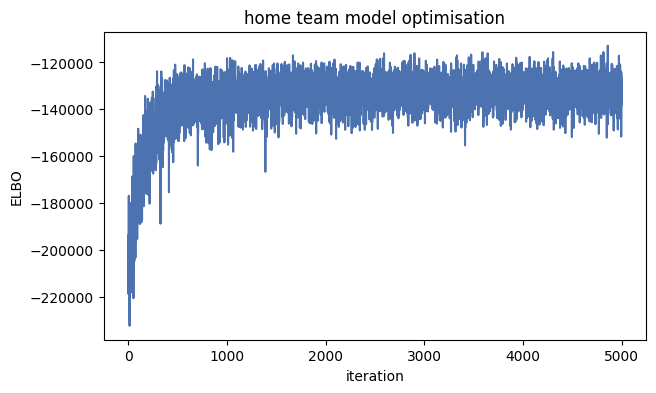

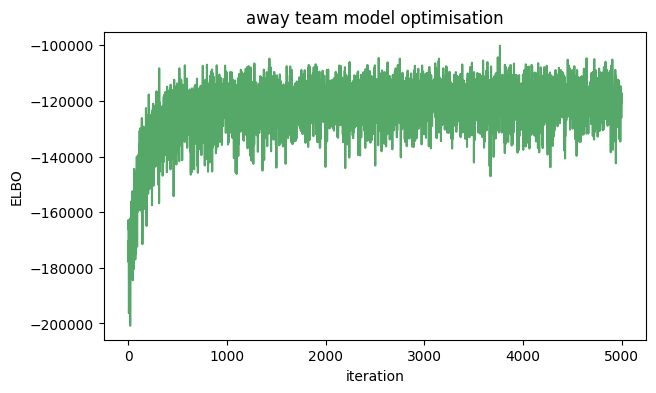

In [14]:
# Optimisation parameters
minibatch_size = 100
learning_rate = 0.001
iterations = 5000

# Train model for predicting home team scores
home_elbos = optimise_svgp_with_adam(
    model=home_model,
    data=home_train_data,
    lr=learning_rate,
    batch_size=minibatch_size,
    iters=iterations,
)

# Plot home team optimisation results
fig = plot_elbos(home_elbos, title="home team model optimisation", colour="C0")
plt.show()

# Train model for predicting away team scores
away_elbos = optimise_svgp_with_adam(
    model=away_model,
    data=away_train_data,
    lr=learning_rate,
    batch_size=minibatch_size,
    iters=iterations,
)

# Plot away team optimisation results
fig = plot_elbos(away_elbos, title="away team model optimisation", colour="C1")
plt.show()

### Evaluate Models
---

To evaluate our models, we will need to make predictions on our held out test dataset. This involves computing the distribution of unseen target values $\mathbf{y^*}$ at input values $\mathbf{X^*}$, called the predictive distribution $p(\mathbf{y^*}|\mathbf{y})$. We get the predictive distribution by marginalising the joint $p(\mathbf{y^*}, \mathbf{f^*} | \mathbf{y})$ over the latent function values $\mathbf{f^*}$:

$p(\mathbf{y^*}|\mathbf{y}) = \int p(\mathbf{y^*}, \mathbf{f^*} | \mathbf{y}) d\mathbf{f^*} = \int p(\mathbf{y^*} | \mathbf{f^*}) p(\mathbf{f^*} | \mathbf{y}) d\mathbf{f^*}$.

Note that in our case, our likelihood actually depends on $\mathbf{\lambda} = \exp(\mathbf{f})$, not $\mathbf{f}$ (as we need to ensure the Poisson rate parameter is non-negative). Fortunately, since the posterior on $\mathbf{f}$ is Gaussian, the posterior on $\mathbf{\lambda}$ is log-Gaussian. Denoting the approximate posterior on the rate parameter $q(\mathbf{\lambda}) = q(\mathbf{\exp(\mathbf{f})})$, our predictive distribution is given by:

$p(\mathbf{y^*}|\mathbf{y}) = \int p(\mathbf{y^*} | \mathbf{\lambda^*}) q(\mathbf{\lambda^*}) d\mathbf{\lambda^*}$,

i.e. we marginalise over the rate parameter. GPflow computes this integral using Gauss-Hermite quadrature, and returns and expectation and variance of the predictive distribution. For a Poisson distribution, the expectation and variance are equal to the rate parameter *given the rate parameter*; however, they will be slightly different in our case as we are marginalising out uncertainty in the rate. While our targets are counts, our predictive expectations will likely be floats. Thus, we will evaluate the mean predictive accuracy two ways:

- Using raw mean predictions
- Using quantised (rounded to the nearest integer) mean predictions

The metric we will use is mean absolute error (MAE):

$MAE = \frac{1}{N} \sum_{i=1}^{N} |y_{i}^{*} - \mu_{i}^{*}|$

where $\mu_{i}^{*}$ is the predictive mean at input $\mathbf{x}_{i}^{*}$. As noted earlier, the targets generally have high variance, so it's also good to evaluate our model using a metric which takes uncertainty into account. For this, we will use negative log predictive density (NLPD), which is less interpretable than MAE (as it is not in units of the target variable), but is a useful metric as it assesses how much probability the predictive distribution assigns to the test observations:

$NLPD = - \sum_{i=1}^{N} \log p(y_{i}^{*} | \mathbf{y})$


In [15]:
# Compute mean predictions on the test set
home_mu_pred, _ = home_model.predict_y(features_test)
away_mu_pred, _ = away_model.predict_y(features_test)

# Quantise mean predictions
home_mu_pred_quantised = tf.round(home_mu_pred)
away_mu_pred_quantised = tf.round(away_mu_pred)

# Compute MAE
home_mae = tf.reduce_mean(tf.abs(home_score_test - home_mu_pred))
away_mae = tf.reduce_mean(tf.abs(away_score_test - away_mu_pred))

# Compute quantised MAE
home_mae_quantised = tf.reduce_mean(tf.abs(home_score_test - home_mu_pred_quantised))
away_mae_quantised = tf.reduce_mean(tf.abs(away_score_test - away_mu_pred_quantised))

# Compute NLPD
home_nlpd = tf.reduce_sum(home_model.predict_log_density(home_test_data))
away_nlpd = tf.reduce_sum(away_model.predict_log_density(away_test_data))

# Print results
print("Home Team Model\n---------------")
print(f"MAE: {home_mae}")
print(f"QMAE: {home_mae_quantised}")
print(f"NLPD: {home_nlpd}")
print("\nAway Team Model\n---------------")
print(f"MAE: {away_mae}")
print(f"QMAE: {away_mae_quantised}")
print(f"NLPD: {away_nlpd}")

Home Team Model
---------------
MAE: 1.0028488360956702
QMAE: 0.9764138006691898
NLPD: -56142.24197043275

Away Team Model
---------------
MAE: 0.8854337296945983
QMAE: 0.8614996434644288
NLPD: -51298.060105451674


As expected, the mean predictive accuracy isn't amazing (on the order of around 1 goal for each model, which is fairly significant -- we probably won't get rich quick using this model for sport betting). Overall, the quantised mean predictive performance appears to be a bit better than the raw mean predictive performance. The home team model has worse mean predictive accuracy but better NLPD than the away team model.

### Potential Improvements
---

There are several ways we could improve our model:

1. Gather more features. We don't know what the mystery features represent, but given that they are continuous, they almost certainly don't represent the home and away teams in each match. Having access to this information could be very useful, as there are likely interesting correlations to exploit for certain matchups (e.g. do Tottenham tend to play worse than average against Arsenal?). Home teams generally have a psychological advantage due to support in the crowd, so there might be some extra signal to exploit here.
2. Engineer better features. It's difficult to perform feature engineering with the mystery features since we don't know what they represent, but it's possible that some transformation or combination of the two would have stronger correlation with the target(s) than the features alone.
3. Model home and away scores jointly. Using a multi-output kernel with two latent GP's could improve the model predictions slightly, even though the correlation between the home and away scores is weak.
4. Use more inducing variables. We used 100 inducing variables (essentially 10 per feature). Our sparse approximation will recover the true solution better if we use more inducing variables (but will take longer to train).
5. Use larger minibatches. Larger minibatches will reduce the variance in our gradients (but will take longer to train).
6. Use a different optimiser. We used ADAM, but it could be worth exploring other optimisation routines like L-BFGS (second order).
7. Try a sampling-based approach rather than variational inference. In some circumstances, MCMC-based inference can perform better than variational inference for approximate GP regression. This could be worth exploring.

### References
---

- [1] https://mvdw.uk/vanderwilk-thesis.pdf
- [2] https://gpflow.github.io/GPflow/2.7.0/index.html
